# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов. Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Необходимо получить значение MAE на тестовой выборке не больше 8.

Последовательность решения задачи:
1. Загрузка и исследование данных.
2. Подготовка данных к обучению модели.
3. Построение модели. Для решения данной задачи применим модель на основе нейросети.
4. Анализ работы модели и вывод.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Исследовательский анализ данных

1. Загрузим набор данных.
2. Проанализируем данные.
3. Проанализируем фотографии.

In [2]:
# Загрузка набора данных
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


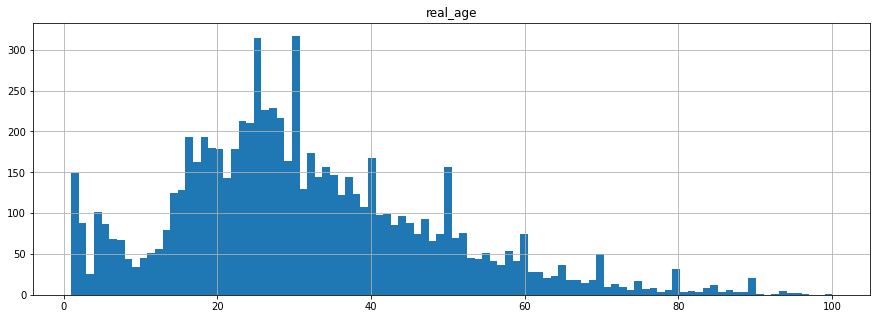

In [5]:
# Гистограма распределения возраста
df.hist(bins=100, figsize=(15,5));

In [6]:
# Посмотрим подробнее на наименее представительные возраста
df['real_age'].value_counts().tail(20)

77     8
84     8
76     7
74     6
79     6
87     6
94     5
82     5
89     4
86     3
78     3
81     3
83     3
88     3
95     2
96     2
93     1
100    1
91     1
97     1
Name: real_age, dtype: int64

In [7]:
# Количество дубликатов
df.duplicated().sum()

0

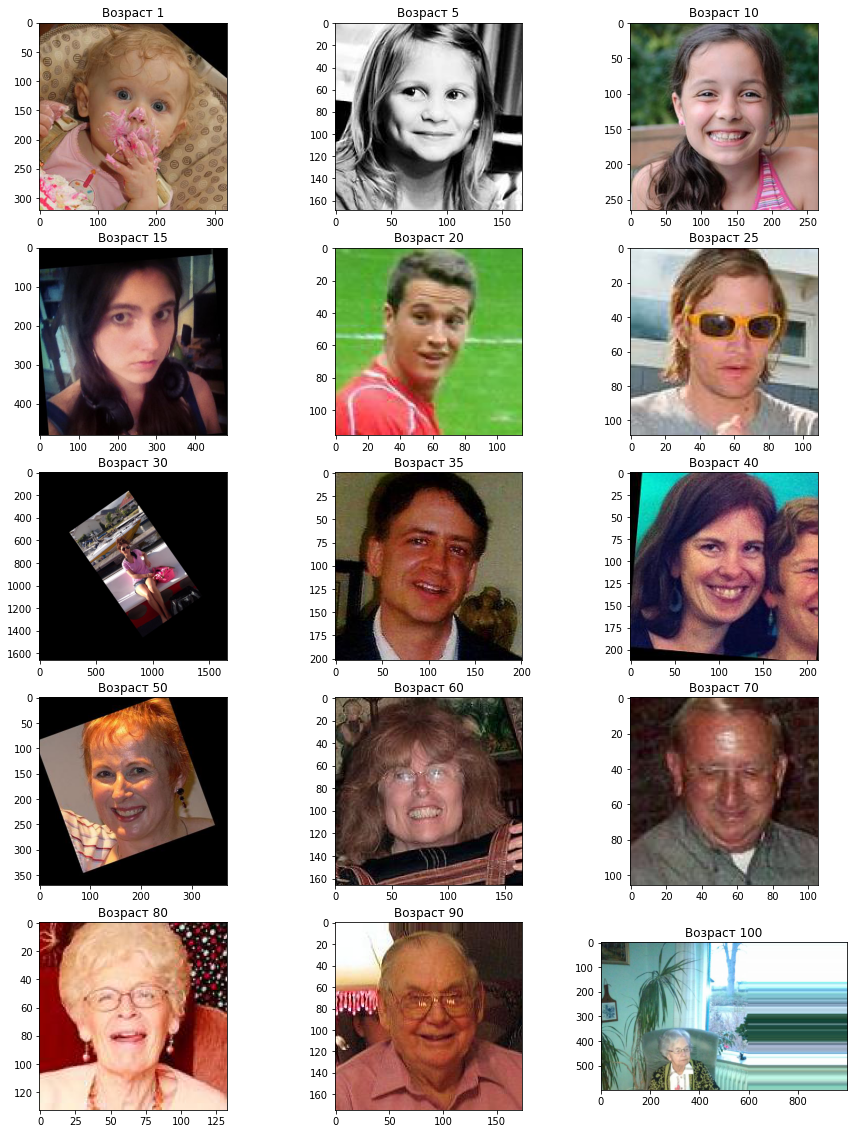

In [8]:
# Выделим по одной фотографии каждого возраста
one_file_age = df.groupby('real_age')['file_name'].min()
# Выберем возраст, фотограйии которого будем выводить на экран
selected_age = [1,5,10,15,20,25,30,35,40,50,60,70,80,90,100]

# Вывод на экран 12 фотографий
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,20))

n = 0
for ax in axes.flat:
    ax.set(title=(f'Возраст {selected_age[n]}'))
    image = Image.open('/datasets/faces/final_files/' + one_file_age[selected_age[n]])
    ax.imshow(image)
    n += 1
plt.show()

**Вывод**

1. Набор данных содержит 7591 фотографию. Данного количества может не хватить для обучения нейросети. Для увеличения выборки, на этапе предобработки применим добавление аугментаций.
2. Пропусков и дубликатов в данных нет.
3. Анализ возраста в датасете:
    - Диапозон возрастов от 1 до 100 лет.
    - Средний возраст 31 год, медианный 29.
    - Большая часть возрастов людей на представленных фотографиях лежит в диапозоне от 20 до 40 лет.
    - Люди старшего возраста в наборе данных представленны достаточно слабо: по 1-5 фотографий. Это связано с тем, что фотографии собирались из общедоступных интернет-хранилищ, где наиболее представленны именно молодые люди. Данный факт может стать фактором, ухудшающим качество будущей модели. Частичному решению данной проблемы, также послужит добавление аугментаций.
    - На гистограмме наблюдаются пики в районе круглых десятков лет. Это может быть связано с тем, что в наборе данных присутствуют как реальные данные о возрасте, так и данные полученные путём разметки возраста методом оценки кажущегося возраста несколькими оценщиками. Видимо чаще всего оценщики определяли возраст с точностью 10 лет. Думаю, это не должно сильно повлиять на работу модели.
4. Анализ фотографий:
    - Фотографии в наборе данных имеют разный размер.
    - Большенство фотографий предобработаны. В них изменёи угол поворота и произведена обрезка по размеру лица. Это положительно повлияет на качество обучения модели. Однако, на некоторых фотографиях лица людей занимают лишь малую часть фотографии. Поэтому будущая модель будет обучатся не столько -на лицах людей, сколько на окружающей обстановке, которая не имеет отношения к возрасту человека. Например единственная 100--летняя бабушка сидит в углу фотографии, и её лицо занимает менее 5% фотографии.
    - Также, встречаются фотографии, где в кадр попадают и лица других людей, что может негативно сказаться на качестве модели.

## Подготовка данных и обучение модели

Для обучения модели в тренажёре ЯП на GPU, создадим необходимые функции:
1. `load_train`. Функция будет возвращать загрузчик тренировачного набора даннных. В данном загрузчике изображения будут приводится к одному размеру. Также, для увеличения тренировочной выборки и частичного решения проблемы наличия малого количества фотографий людей старшего возраста, добавим аугментации в тренировочные данные. Думаю, к изображениям лиц, будет допустимо применить смещения и поворот по горизонтали. 
2. `load_test`. Функция будет возвращать загрузчик трестового набора даннных. В данном загрузчике изображения будут приводится к одному размеру. Аугментации в тестовые данные добавлять не будем.
3. `create_model`. Функция будет возвращать модель. Создание нейросетевой модели с нуля считаю не целесообразным, поэтому создавать модель будем на основе существующих архитектур. Для построения модели будем использовать модель с архитектурой `ResNet50` из библиотеки Keras. Вместо последних двух слоёв `ResNet50` добавим слои:
    - GlobalAveragePooling2D - для усреднения информации по всему изображению на выходе из ResNet50;
    - Dense(64, activation='relu') - для снижения размерности признаков;
    - Dense(1, activation='relu') - выходной слой, выдающий значение прогнозируемого возраста.
    
    Компиляцию модели осуществим со следующими параметрами:
    - Оптимизатор `Adam` или `Adamax`, а также его параметр `learning_rate` подоберём опытным путём;
    - Функцию потерь `MSE`;
    - Метрику качества `MAE`
4. `train_model`. Функция будет обучать модель и возвращать модель после обучения. Оптимальное количество эпох обучения, подберём опытным путём.

Из множества попыток обучения моделей в таблице представлены лучшие из них:


| Модель | Оптимизатор |  learning_rate | Количество эпох | MAE |
| :----- | :-----------| :------------- |:----------------|:--- |
| ResNet50 | Adam | 0.0003 | 10 | 6.25 |
| ResNet50 | Adam | 0.0003 | 15 | 6.08 |
| ResNet50 | Adamax | 0.0003 | 15 | 6.09 |
| ResNet50 | Adamax | 0.0004 | 15 | 5.99 |

Ниже представлен код для лучшей модели.

```python
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet import ResNet5050
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def load_train(path):
    """ Принимаем путь к папке.
        Возвращаем загрузчик тренировочных данных.
    """
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 rescale=(1/255),
                                 horizontal_flip=True,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2
                                )
    labels = pd.read_csv(path+'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory=path+'final_files/',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                subset='training',
                                seed=12345)
    print('train shape =', len(train_datagen_flow.filenames))
    return train_datagen_flow

def load_test(path):
    """ Принимаем путь к папке.
        Возвращаем загрузчик тестовых данных.
    """
    datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255))
    labels = pd.read_csv(path+'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory=path+'final_files/',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                subset='validation',
                                seed=12345)
    print('test shape =', len(test_datagen_flow.filenames))
    return test_datagen_flow

def create_model(input_shape):
    """ Принимаем размер входных данных.
        Возвращаем модель.
    """
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adamax(lr=0.0004)
    
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    model.summary()
    return model


def train_model(model, train_datagen, test_datagen, batch_size=16, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    """ Принимаем модель, данные и параметры для обучения модели.
        Возвращаем обученную модель.
    """
    model.fit(train_datagen, 
              validation_data=test_datagen,
              #batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Using TensorFlow backend.
Found 5694 validated image filenames.
train shape = 5694
Found 1897 validated image filenames.
test shape = 1897
2022-07-13 19:35:04.733877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-13 19:35:04.744082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-13 19:35:04.744462: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-07-13 19:35:04.752088: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-07-13 19:35:04.752599: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x50c2b70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-13 19:35:04.752629: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-13 19:35:04.905429: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5148b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-13 19:35:04.905475: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-07-13 19:35:04.908150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-13 19:35:04.913082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-13 19:35:04.913162: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-13 19:35:05.246185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-07-13 19:35:05.246235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-07-13 19:35:05.246243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-07-13 19:35:05.251043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
=================================================================
Total params: 23,718,913
Trainable params: 23,665,793
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
libcudnn.so.7
178/178 - 97s - loss: 176.6760 - mae: 9.9276 - val_loss: 698.6928 - val_mae: 21.4726
Epoch 2/15
178/178 - 89s - loss: 89.3829 - mae: 7.1357 - val_loss: 517.6656 - val_mae: 17.6215
Epoch 3/15
178/178 - 89s - loss: 68.7198 - mae: 6.3560 - val_loss: 300.5571 - val_mae: 12.9166
Epoch 4/15
178/178 - 89s - loss: 56.9965 - mae: 5.8055 - val_loss: 135.3009 - val_mae: 8.8722
Epoch 5/15
178/178 - 89s - loss: 45.8345 - mae: 5.2001 - val_loss: 97.2904 - val_mae: 7.3395
Epoch 6/15
178/178 - 90s - loss: 42.8923 - mae: 5.0417 - val_loss: 104.2981 - val_mae: 7.6228
Epoch 7/15
178/178 - 90s - loss: 36.2574 - mae: 4.6215 - val_loss: 75.9895 - val_mae: 6.3623
Epoch 8/15
178/178 - 90s - loss: 30.6221 - mae: 4.2677 - val_loss: 83.9318 - val_mae: 6.9085
Epoch 9/15
178/178 - 89s - loss: 27.0304 - mae: 3.9906 - val_loss: 76.9277 - val_mae: 6.4816
Epoch 10/15
178/178 - 89s - loss: 25.0032 - mae: 3.8467 - val_loss: 76.4961 - val_mae: 6.4577
Epoch 11/15
178/178 - 89s - loss: 24.2225 - mae: 3.7803 - val_loss: 66.6875 - val_mae: 6.0984
Epoch 12/15
178/178 - 89s - loss: 21.5059 - mae: 3.5689 - val_loss: 74.6638 - val_mae: 6.2791
Epoch 13/15
178/178 - 90s - loss: 21.0776 - mae: 3.5277 - val_loss: 86.1203 - val_mae: 6.7926
Epoch 14/15
178/178 - 90s - loss: 18.5928 - mae: 3.3313 - val_loss: 73.9482 - val_mae: 6.3084
Epoch 15/15
178/178 - 89s - loss: 17.9108 - mae: 3.2539 - val_loss: 67.8779 - val_mae: 5.9959
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 67.8779 - mae: 5.9959
Test MAE: 5.9959
```

**Вывод**

Метрика МАЕ на тестовом наборе данных составила 5.99, что ниже целевого показателя 8. Таким образом, достигнуто необходимое качество модели. Опытным путём были подобраны:
   - Оптимизатор `Adamax`;
   - Параметр оптимизатора learning_rate=0.0004;
   - Количество эпох = 15
   - Количество нейронов в предпоследнем слое = 64.

## Анализ обученной модели

Была поставлена задача создания модели, которая по фотографии определит приблизительный возраст человека.

Сначала был произведён анализ представленного датасета. Проблем и ошибок, мешающих созданию модели по имеемым данным выявлено небыло. Были выявлены факторы, которые могли быть причиной снижения качества модели: малое количество фотографий лиц старшего возраста и наличие фотографий, на которых лицо занимает малую часть фотографии.

Создание модели с нуля могло-бы занять большое количество времени(и не гарантировало-бы результат). Поэтому было принято решение создавать модель на основе извесных архитектур имеемых в библиотеке Keras. Выбор архитектуры ResNet50 обусловлен тем, что модели на её основе вполне по плечу решение поставленной задачи, и при этом время решения и вычислительная нагрузка будет лежать в разумных пределах. Последние два слоя модели ResNet50 были заменены на три слоя, наиболее подходящих под задачу. 

Созданная модель показала достаточное качество со значением MAE = 5.99, что ниже целевого показателя. Таким образом можно сделать вывод, что задача создания модели определения приблизительного возраста человека по фотографии решена.

Для дальнейшего повышения качества модели, можно попробовать применить другие известные архитектуры нейросетей, а также поработать над качеством и количеством фотографий в обучающем наборе данных.